<a href="https://colab.research.google.com/github/JUNYA-727/JUNYA-727/blob/main/TECHNOPRO5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import os
import glob 
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
import zipfile
import pandas as pd
import csv

In [2]:
os.makedirs('/content/dataset/train/image')
os.makedirs('/content/dataset/train/mask')
os.makedirs('/content/dataset/valid/image')
os.makedirs('/content/dataset/valid/mask')

In [3]:
with open('/content/drive/MyDrive/signate/train_annotations.tsv',encoding='utf-8',newline='') as f:
  reader=csv.reader(f,delimiter='\t')
  header=next(reader)
  base_dir='/content/drive/MyDrive/signate/train 2'
  a_count=0
  b_count=0
  c_count=0
  d_count=0
  for cols in reader:
    if cols[1]=='1':
      image_path=os.path.join(base_dir,cols[0]+'.png')
      img=cv2.imread(image_path)
      semi_major=float(cols[3])
      semi_minor=float(cols[4])
      rotation_angle=float(cols[5])*90
      x=float(cols[6])
      y=float(cols[7])
      mask=np.zeros(img.shape,dtype=np.uint8)
      if cols[2]=='A':
        a_count+=1
        cv2.ellipse(mask,((x,y),(semi_major*2,semi_minor*2),rotation_angle),(255,255,255),-1)
        #val
        if a_count<6:
          #mask
          cv2.imwrite(os.path.join('/content/dataset/valid/mask',cols[0]+'.jpg'),mask)
          #image
          cv2.imwrite(os.path.join('/content/dataset/valid/image',cols[0]+'.jpg'),img)
        else:
          #mask
          cv2.imwrite(os.path.join('/content/dataset/train/mask',cols[0]+'.jpg'),mask)
          #image
          cv2.imwrite(os.path.join('/content/dataset/train/image',cols[0]+'.jpg'),img) 
      if cols[2]=='B':
        b_count+=1
        cv2.ellipse(mask,((x,y),(semi_major*2,semi_minor*2),rotation_angle),(255,255,0),-1)
        #val
        if b_count<6:
          #mask
          cv2.imwrite(os.path.join('/content/dataset/valid/mask',cols[0]+'.jpg'),mask)
          #image
          cv2.imwrite(os.path.join('/content/dataset/valid/image',cols[0]+'.jpg'),img)
        else:
          #mask
          cv2.imwrite(os.path.join('/content/dataset/train/mask',cols[0]+'.jpg'),mask)
          #image
          cv2.imwrite(os.path.join('/content/dataset/train/image',cols[0]+'.jpg'),img)   
      if cols[2]=='C':
        c_count+=1
        cv2.ellipse(mask,((x,y),(semi_major*2,semi_minor*2),rotation_angle),(255,0,255),-1)
        #val
        if c_count<6:
          #mask
          cv2.imwrite(os.path.join('/content/dataset/valid/mask',cols[0]+'.jpg'),mask)
          #image
          cv2.imwrite(os.path.join('/content/dataset/valid/image',cols[0]+'.jpg'),img)
        else:
          #mask
          cv2.imwrite(os.path.join('/content/dataset/train/mask',cols[0]+'.jpg'),mask)
          #image
          cv2.imwrite(os.path.join('/content/dataset/train/image',cols[0]+'.jpg'),img)   
      if cols[2]=='D':
        d_count+=1
        cv2.ellipse(mask,((x,y),(semi_major*2,semi_minor*2),rotation_angle),(0,255,255),-1)
        #val
        if d_count<6:
          #mask
          cv2.imwrite(os.path.join('/content/dataset/valid/mask',cols[0]+'.jpg'),mask)
          #image
          cv2.imwrite(os.path.join('/content/dataset/valid/image',cols[0]+'.jpg'),img)
        else:
          #mask
          cv2.imwrite(os.path.join('/content/dataset/train/mask',cols[0]+'.jpg'),mask)
          #image
          cv2.imwrite(os.path.join('/content/dataset/train/image',cols[0]+'.jpg'),img)   

In [ ]:
!git clone https://github.com/ahmedfgad/Mask-RCNN-TF2.git

In [ ]:
!pip install -r '/content/Mask-RCNN-TF2/requirements.txt'

In [6]:
cd /content/Mask-RCNN-TF2

/content/Mask-RCNN-TF2


In [7]:
import tensorflow 
import keras
import skimage
from mrcnn import utils
import pathlib
from PIL import Image
import copy
from mrcnn.config import Config
import mrcnn.model
import urllib.request

Using TensorFlow backend.


In [8]:
class OneClassConfig(Config):
  NAME='dataset'

  IMAGES_PER_CPU=1

  NUM_CLASSES=2

  STEP_PER_EPOCH=50

  DETECTION_MIN_CONFIDENCE = 0.9

In [9]:
class OneClassDataset(utils.Dataset):
  def load_dataset(self,dataset_dir):
    self.add_class('dataset',1,'clack')
    images=glob.glob(os.path.join(dataset_dir,'image','*.jpg'))
    masks=glob.glob(os.path.join(dataset_dir,'mask','*.jpg'))
    for image_path,mask_path in zip(images,masks):
      image_path=pathlib.Path(image_path)
      mask_path=pathlib.Path(mask_path)
      assert image_path.name==mask_path.name,'データセットがずれています'
      image=Image.open(image_path)
      height=image.size[0]
      width=image.size[1]
      mask=Image.open(mask_path)
      assert image.size==mask.size,'サイズがずれています'
      self.add_image(
          'dataset',
          path=image_path,
          image_id=image_path.stem,
          mask_path=mask_path,
          width=width,height=height
      )
  def load_mask(self,image_id):
    image_info=self.image_info[image_id]
    if image_info['source']!='dataset':
      return super(self.__class__,self).load_mask(image_id)
    mask_path = image_info['mask_path']
    mask, cls_idxs = blob_detection(str(mask_path))

    return mask, cls_idxs
  def image_reference(self, image_id):
      info = self.image_info[image_id]
      if info["source"] == 'dataset':
          return info
      else:
          super(self.__class__, self).image_reference(image_id)
def blob_detection(mask_path):
    mask = cv2.imread(mask_path, 0)
    _, mask = cv2.threshold(mask, 150, 255, cv2.THRESH_BINARY)

    label = cv2.connectedComponentsWithStats(mask)
    data = copy.deepcopy(label[1])

    labels = []
    for label in np.unique(data):
        if label == 0:
            continue
        else:
            labels.append(label)

    mask = np.zeros((mask.shape)+(len(labels),), dtype=np.uint8)

    for n, label in enumerate(labels):
        mask[:, :, n] = np.uint8(data == label)

    cls_idxs = np.ones([mask.shape[-1]], dtype=np.int32)

    return mask, cls_idxs

In [10]:
TRAIN_DATASET='/content/dataset/train'
dataset_train=OneClassDataset() 
dataset_train.load_dataset(TRAIN_DATASET)
dataset_train.prepare()
VALID_DATASET='/content/dataset/valid'
dataset_val=OneClassDataset()
dataset_val.load_dataset(VALID_DATASET)
dataset_val.prepare()
config=OneClassConfig()
model = mrcnn.model.MaskRCNN(mode="training", config=config,
                          model_dir='/content/models')
urllib.request.urlretrieve('https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5','mask_rcnn_coco.h5')
COCO_MODEL_PATH = 'mask_rcnn_coco.h5'
model.load_weights(COCO_MODEL_PATH, by_name=True,
                    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                            "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
#学習開始
model.train(dataset_train, dataset_val,
            learning_rate=0.001,
            epochs=10,
            layers='heads')

In [12]:
model.keras_model.save_weights("/content/mask_rcnn.h5")

In [13]:
model.load_weights(filepath='/content/mask_rcnn.h5',by_name=True)

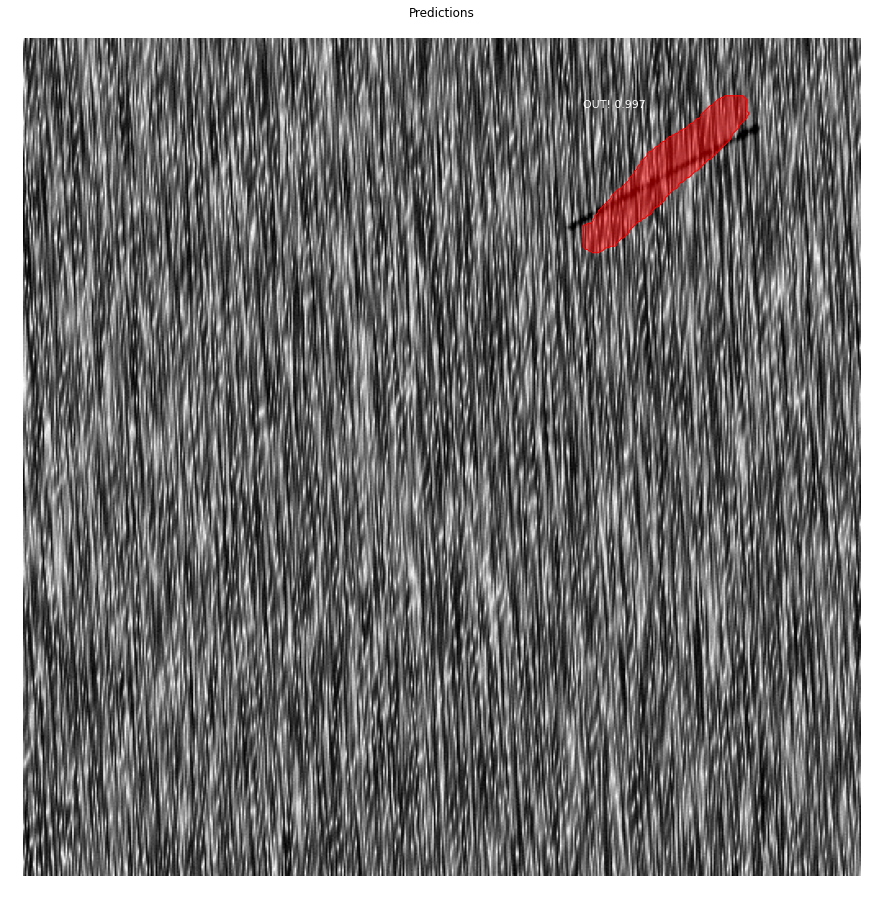

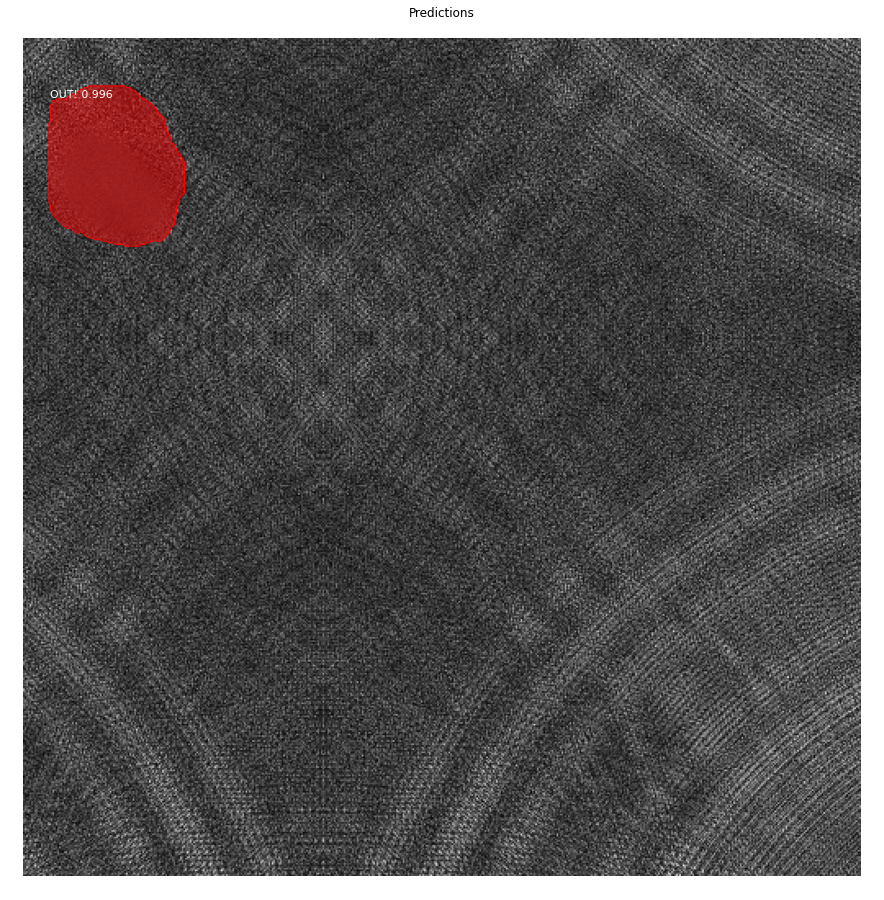

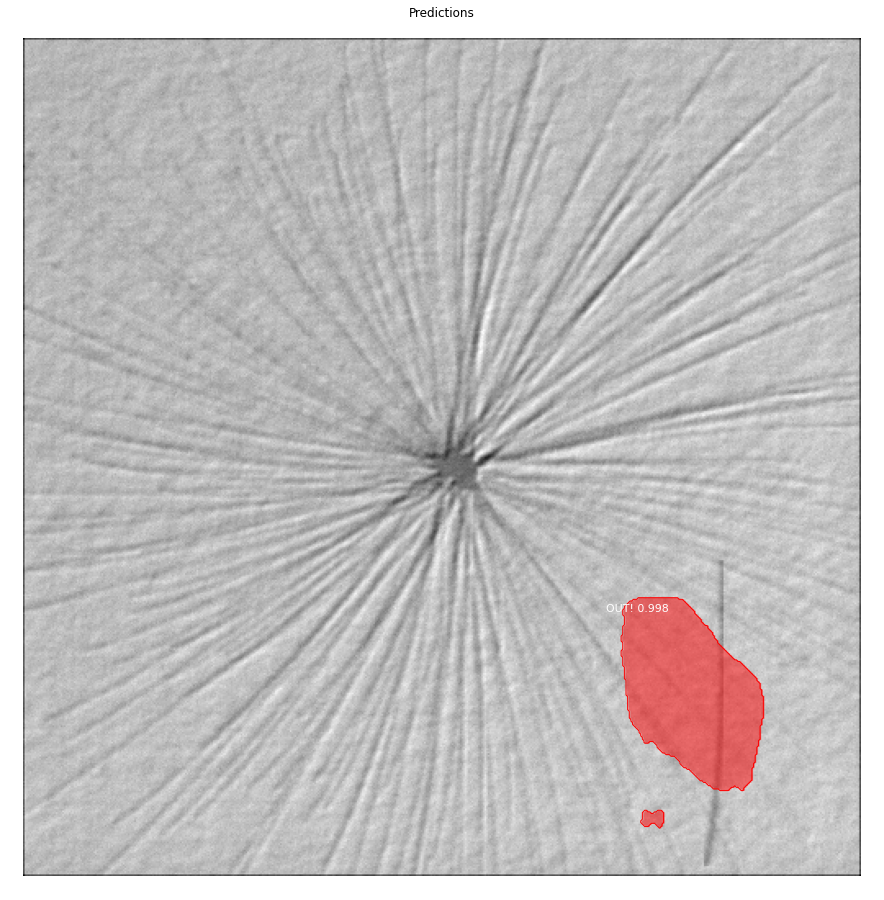

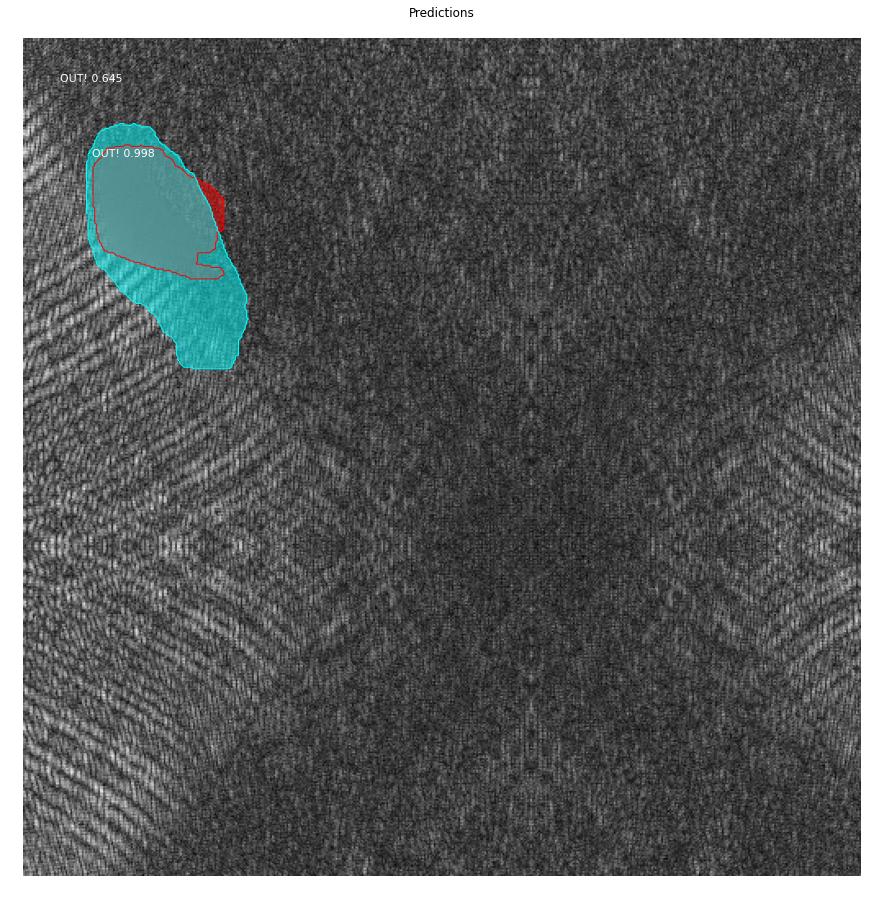

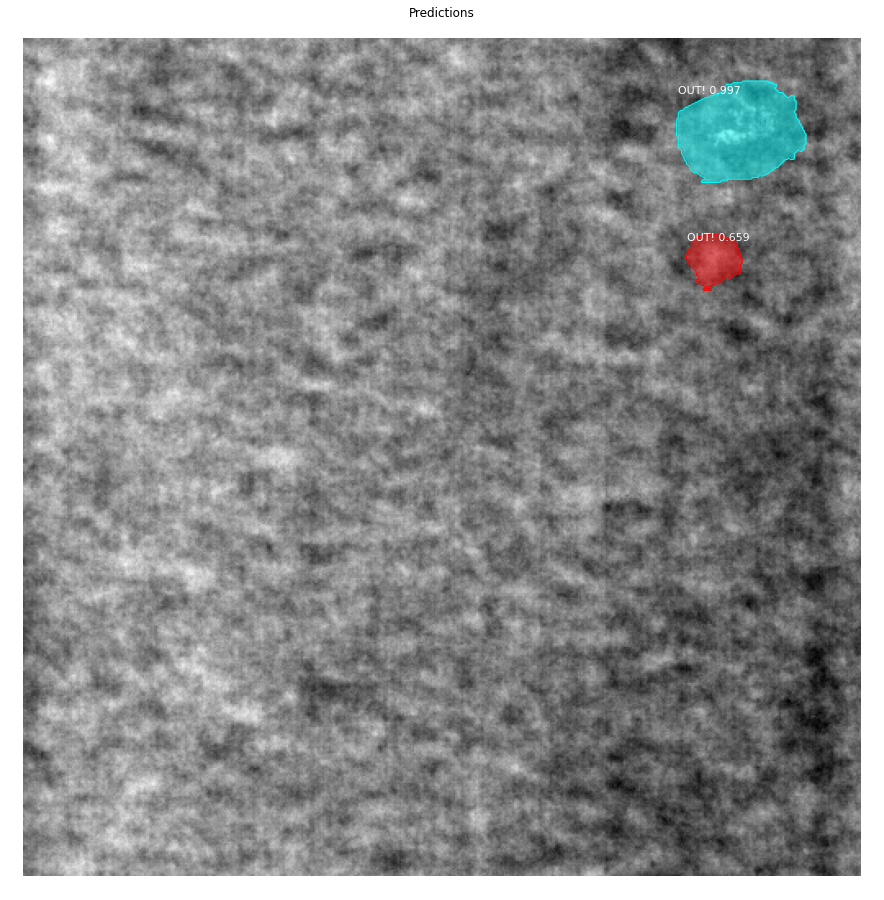

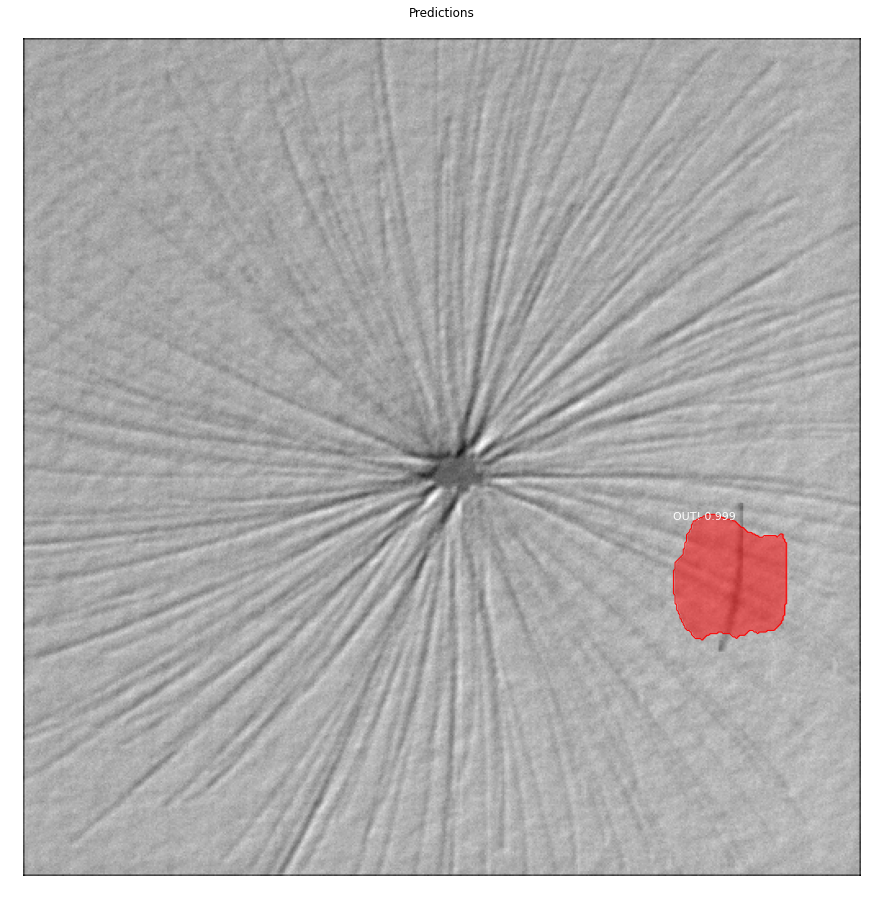

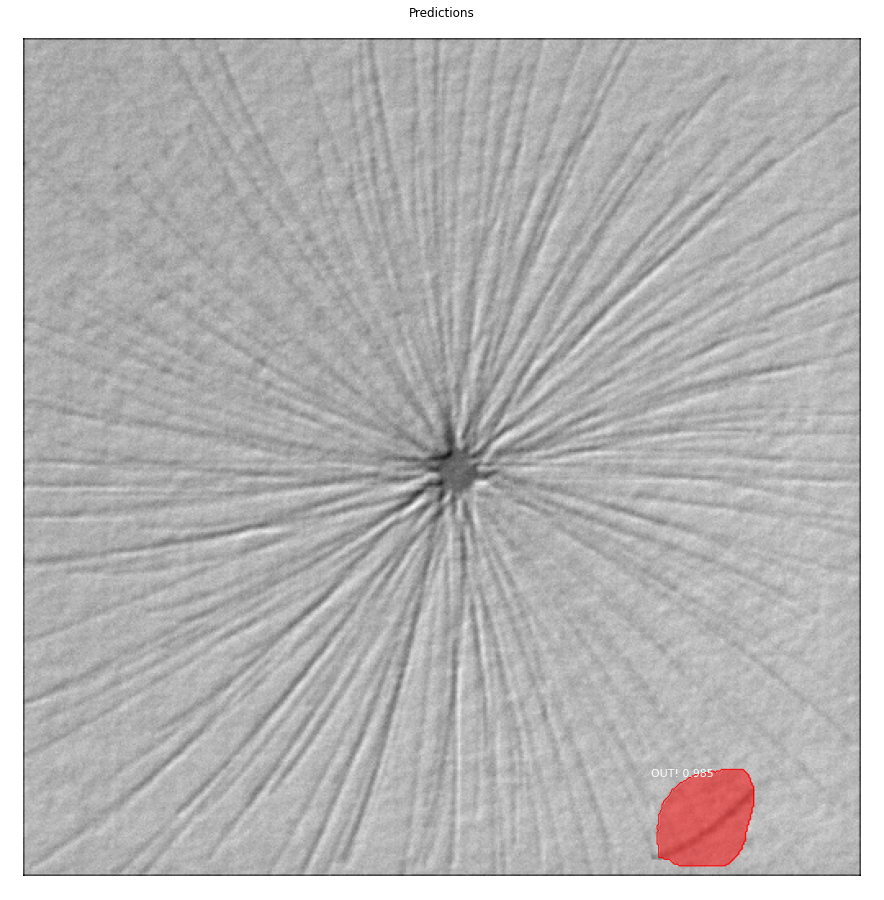

In [44]:
from mrcnn import visualize

class InferenceConfig(OneClassConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.5
config = InferenceConfig()
model = mrcnn.model.MaskRCNN(mode="inference", config=config,
                          model_dir=None)
model.load_weights('/content/mask_rcnn.h5', by_name=True)
valid_path=glob.glob('/content/dataset/valid/image/*.jpg')
class_name=['none','OUT!']
for i,path in enumerate(valid_path):
  if i>6:
    break
  image=cv2.imread(path)
  r=model.detect([image])
  r=r[0]
  mrcnn.visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],class_name,r['scores'],show_bbox=False,title="Predictions")

In [ ]:
test_dir='/content/drive/MyDrive/signate/test'
with open('/content/drive/MyDrive/signate/sample_submit.tsv',encoding='utf-8') as f:
  contents=[]
  for cols in csv.reader(f,delimiter='\t'):
    content=[]
    img_id=cols[0]
    img_path=os.path.join(test_dir,img_id+'.png')
    image=cv2.imread(img_path)
    r=model.detect([image])
    r=r[0]
    #物体検出
    if len(r['class_ids']) != 0:
      content.append(img_id)
      content.append('1')
      print(img_id,len(r['class_ids']))
    else:
      content.append(img_id)
      content.append('0')
      print(img_id,len(r['class_ids']))
    contents.append(content)
with open('/content/signate_mask.tsv','w') as f:
  for content in contents:
    f.write(content[0]+'\t'+content[1])
    f.write('\n')
  